In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import seaborn as sns
sns.set_theme(style="ticks", font_scale=2)
import os
import json
from datetime import datetime
import inspect
import os
import sys
import importlib
import matplotlib.gridspec as gridspec

sys.path.append('../Classes')
import sgh_class

import colorsys
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
red = ['#fda2b7', '#d10333', '#6c011a']
yellow = ['#fde69a', '#f9c105', '#c79b04']
blue = ['#3fb5fb', '#0384d0', '#02456c']
p = np.linspace(0.01/180, 600/180, 500)

In [3]:
run_code = False

if run_code:
    x = sgh_class.SGH_class()
    x.params.update(tree_root_active=0, shading_active=1)
    sol0 = []; sol1 = [];
    for precip in p:
        sol0.append(x.solutions_fsolve(p=precip, c=0))
        sol1.append(x.solutions_fsolve(p=precip, c=0.5))
    combined_array = np.hstack([p.reshape(-1, 1), np.array(sol0), np.array(sol1)])
    combined_array[:,[1,3]] *= 1000  # convert biomass from kg to g
    np.savetxt('cartoon.csv', combined_array)

data = np.loadtxt('cartoon.csv')

(p, B0, S0, B1, S1) = data.T

# sol0 = x.
# B_zero = s1.B_of_P(p, 0)
B_zero = B0
B_tc_1 = B1

In [4]:
abs_diff = np.abs(B_zero - B_tc_1)[10:]
index = np.argmin(abs_diff) + 10  # +10 because we skipped the first 10 elements
intersection_p = p[index]
intersection_B = B_zero[index]

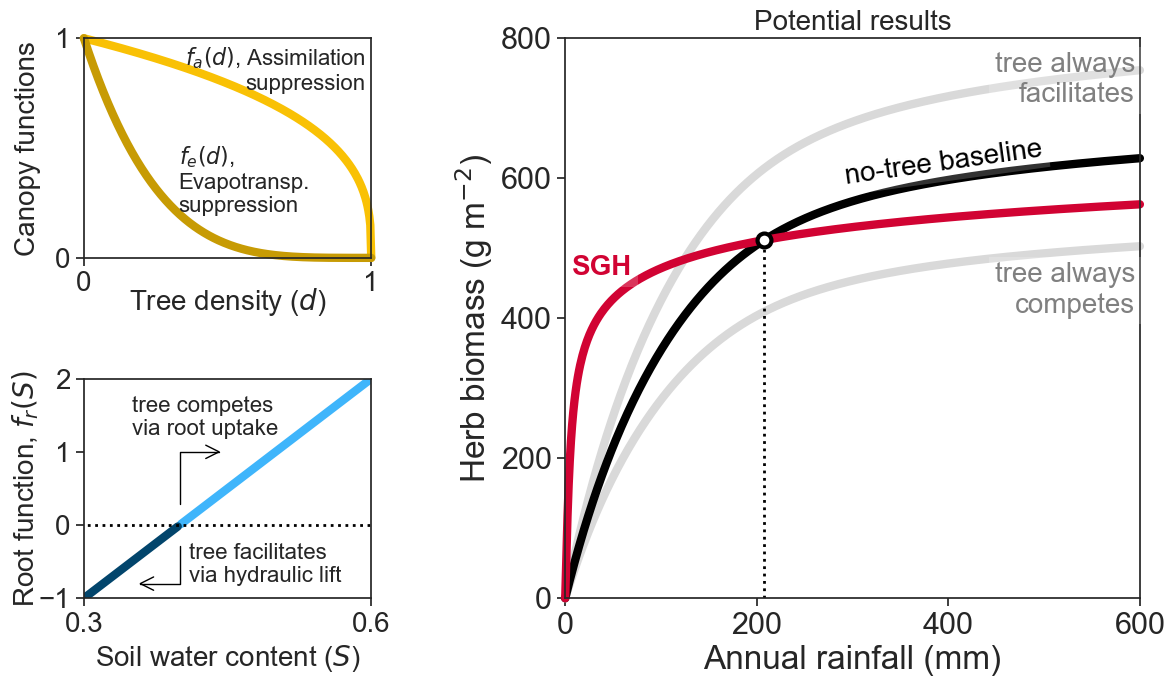

In [9]:
fig = plt.figure(figsize=(12, 7))
# fig, ax = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [0.5, 1], 'height_ratios': [1, 1]})
# fig.subplots_adjust(top=0.95, bottom=0.08, wspace=0.3, hspace=0.4, left=0.08, right=0.98)

gs = fig.add_gridspec(2,2, width_ratios=[0.5, 1], height_ratios=[1, 1])
fig.subplots_adjust(top=0.95, bottom=0.15, wspace=0.45, hspace=0.55, left=0.08, right=0.96)
ax_cano = fig.add_subplot(gs[0, 0])
ax_root = fig.add_subplot(gs[1, 0])
ax_tran = fig.add_subplot(gs[:, 1])

##################################
# Panels on the TOP of the figure
##################################

cover = np.linspace(0, 1, 300)
ess = cover.copy()
L1 = -1.0
L2 = 2.0
sh = 0.3
sfc = 0.6
m = (L2 - L1) / (sfc - sh)
def fa(c):
    return (1 - c) ** (1/3.0)
def fe(c):
    return (1 - c) ** (4.0)
def relu(x):
    return np.maximum(0, x)
def fr(s):
    return L1 + m*relu(s - sh) - m*relu(s - sfc)

ax_cano.plot(cover, fa(cover), color=yellow[1], lw=6, clip_on=False)
ax_cano.plot(cover, fe(cover), color=yellow[2], lw=6, clip_on=False)
ax_cano.text(
        0.98, 0.97, r'$f_a(d)$,' +' Assimilation\nsuppression',
        fontsize=16, va='top', ha='right',)
ax_cano.text(
        0.33, 0.52, r'$f_e(d)$,' + '\nEvapotransp.\nsuppression',
        fontsize=16, va='top', ha='left',)
ax_cano.set(xlim=(0, 1),
          ylim=(0, 1),
          xticks=[0,1],
          yticks=[0,1],)
ax_cano.set_xlabel(r'Tree density ($d$)', fontsize=20, labelpad=-8)
ax_cano.set_ylabel('Canopy functions', fontsize=20)
ax_cano.tick_params(axis='both', which='major', labelsize=20)

is_lift_mask = np.where(fr(ess)>0, True, False)
ax_root.plot(ess[is_lift_mask], fr(ess[is_lift_mask]), color=blue[0], lw=6, clip_on=True)
ax_root.plot(ess[~is_lift_mask], fr(ess[~is_lift_mask]), color=blue[2], lw=6, clip_on=True)
# ax_root.plot(ess, 0.5*fr(ess), color=blue[0], lw=6, clip_on=True)
ax_root.plot(ess, 0.0*fr(ess), color='black', lw=2, ls=':', clip_on=True)

ax_root.set(xlim=(0.3, 0.6),
          ylim=(-1, 2),
          xticks=[0.3,0.6],
          yticks=[-1,0,1,2])
# ax_root.yaxis.set_label_position("right")
# ax_root.yaxis.tick_right()
ax_root.set_xlabel(r'Soil water content ($S$)', fontsize=20)
# ax_cano.xaxis.set_label_coords(-0.2, 0.50)
ax_root.set_ylabel(r'Root function, $f_r(S)$', fontsize=20)
ax_root.yaxis.set_label_coords(-0.15, 0.50)
ax_cano.yaxis.set_label_coords(-0.15, 0.50)
ax_root.tick_params(axis='both', which='major', labelsize=20)

# ax_cano.set_title("Canopy mechanism", color=yellow[2], fontsize=20)
# ax_root.set_title("Root mechanism", color=blue[2], fontsize=20)

# ax_root.text(0.59, 1.9, r'$d=1$',
#          fontsize=16, verticalalignment='top',
#          horizontalalignment='right',
#          rotation=0,
#          bbox=dict(facecolor='white', alpha=0.3, edgecolor='none')
#          )
# ax_root.text(
#         0.59, 0.8, r'$d=0.5$',
#         fontsize=16, va='center', ha='right',
#         bbox=dict(facecolor='white', alpha=0.3, edgecolor='none')
# )
# ax_cano.text(0.02, 0.02, 'a', transform=ax_cano.transAxes, fontsize=26, weight='bold', ha='left', va='bottom')
# ax_root.text(0.02, 0.98, 'b', transform=ax_root.transAxes, fontsize=26, weight='bold', va='top')
# ax_tran.text(0.02, 0.98, 'c', transform=ax_tran.transAxes, fontsize=26, weight='bold', va='top')

xpos = 0.59
# ax_root.annotate('', xy=(xpos, -0.05), xytext=(xpos, -0.50),
#                  arrowprops=dict(color='black',arrowstyle="<-"))
# ax_root.annotate('', xytext=(xpos, 0.05), xy=(xpos, 0.50),
#                  arrowprops=dict(color='black',arrowstyle="->"))
# ax_root.text(xpos-0.005, 0.4, 'Usage', va='top', ha='right', fontsize=16)
# ax_root.text(xpos-0.005, -0.4, 'Provision', va='bottom', ha='right', fontsize=16)

ax_root.annotate("",
                xy=(0.45, 1.0), xycoords='data',
                xytext=(0.4, 0.0), textcoords='data',
                arrowprops=dict(arrowstyle="->", color="black",
                                shrinkA=15, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="angle,angleA=-90,angleB=180,rad=0",
                                ),
                )
ax_root.text(0.35, 1.17, 'tree competes\nvia root uptake', va='bottom', ha='left', fontsize=16)
ax_root.annotate("",
                xy=(0.35, -0.8), xycoords='data',
                xytext=(0.4, 0.0), textcoords='data',
                arrowprops=dict(arrowstyle="->", color="black",
                                shrinkA=15, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="angle,angleA=-90,angleB=180,rad=0",
                                ),
                )
ax_root.text(0.41, -0.83, 'tree facilitates\nvia hydraulic lift', va='bottom', ha='left', fontsize=16)

##################################
# Panels on the BOTTOM of the figure
##################################

# Synthetic model for left and middle plots
rain = np.linspace(0, 600, 300)
scaling_factor = 600 / 80  # = 7.5

# Shared gray line across both plots
gray_line = scaling_factor * 70 * (1 - np.exp(-0.05 * rain))

# Blue line *below* gray in competition plot (axs[0])
blue_comp = scaling_factor * 55 * (1 - np.exp(-0.05 * rain))

# Blue line *above* gray in facilitation plot (axs[1])
blue_facil = scaling_factor * 85 * (1 - np.exp(-0.05 * rain))

x_vals = p * 180

# Generate synthetic blue curves relative to real gray
blue_comp = 0.8 * B_zero     # always below
blue_facil = 1.2 * B_zero    # always above

# Panel a: Competition (blue < gray)
# Panel a: Competition (blue < gray)
ax_tran.plot(x_vals, blue_comp, color=[0.85]*3, lw=6, clip_on=False)
ax_tran.plot(x_vals, blue_facil, color=[0.85]*3, lw=6, clip_on=False)
ax_tran.plot(x_vals, B_zero, color='black', lw=6, linestyle='-', clip_on=False)  # dotted gray
ax_tran.plot(x_vals, B_tc_1, color=red[1], lw=6, clip_on=False)
ax_tran.plot([intersection_p*180], [intersection_B], 'o', mfc='white', mec="black", mew=3, markersize=10, clip_on=False)

ax_tran.text(
    595, 780, 
    'tree always\nfacilitates', 
    color=[0.5]*3, fontsize=20, ha='right', va='top',
    bbox=dict(facecolor='white', alpha=0.2, edgecolor='none')
)

ax_tran.text(
    595, 480, 
    'tree always\ncompetes', 
    color=[0.5]*3, fontsize=20, ha='right', va='top',
    bbox=dict(facecolor='white', alpha=0.2, edgecolor='none')
)

ax_tran.text(
    500, 660, 
    'no-tree baseline',
    rotation=8,
    color='black', fontsize=20, ha='right', va='top',
    bbox=dict(facecolor='white', alpha=0.2, edgecolor='none')
)

ax_tran.text(
    70, 490, 
    'SGH', weight='bold',
    color=red[1], fontsize=20, ha='right', va='top',
    bbox=dict(facecolor='white', alpha=0.2, edgecolor='none')
)

ax_tran.plot([intersection_p*180, intersection_p*180], [0, intersection_B*0.98], color='black', lw=2, ls=':')

# ax_tran.annotate('transition point', 
#                 xy=(210, 500), 
#                 xytext=(200, 260),
#                 size=20,
#                 ha='left',
#                 va='top',
#                 arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3", linewidth=3))

# ax_tran.text(100, 450, u"\u2460", fontsize=40, color='black', weight='bold', ha='center', va='center')

ax_tran.set(xlim=(0, 600),
          ylim=(0, 800),
          xticks=[0, 200, 400, 600],
          yticks=[0, 200, 400, 600, 800])
ax_tran.set_title("Potential results", fontsize=20)
ax_tran.set_xlabel(r'Annual rainfall (mm)')#, labelpad=0)
# ax_tran.text(300, 10, r'Annual rainfall (mm)', fontsize=20, ha='center', va='bottom')
ax_tran.set_ylabel(r'Herb biomass (g m${}^{-2}$)')

# fig.savefig('schematics2.png', dpi=300)
fig.savefig('schematics3.pdf')


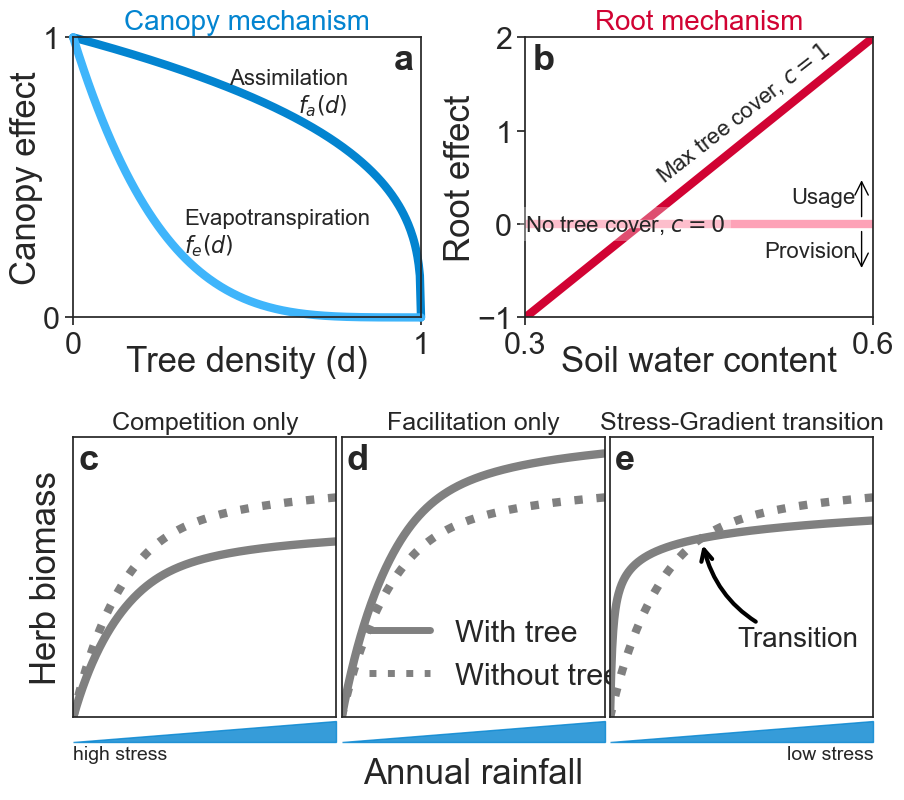

In [7]:
from matplotlib.patches import Polygon

fig = plt.figure(1, figsize=(10,8))  # figsize accepts only inches.


gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=[1])
gs.update(left=0.10, right=0.90, top=0.95, bottom=0.60, hspace=0.02, wspace=0.30)

ax_a1 = plt.subplot(gs[0, 0])#, aspect=1.0)
# aspect options for matplotlib axes:
# - 'auto': fill the subplot box, ignore data aspect
# - 'equal': same scaling for x and y (1:1 aspect ratio)
# - float value: set aspect ratio as y/x (e.g., aspect=0.5 for y half as tall as x)
# Example usage:
# ax_a2 = plt.subplot(gs[0, 1], aspect='auto')   # stretches to fill
# # or
# ax_a2 = plt.subplot(gs[0, 1], aspect='equal')  # 1:1 scaling
# # or
ax_a2 = plt.subplot(gs[0, 1])#, aspect=2.0)      # y twice as tall as x

gs2 = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], height_ratios=[1])
gs2.update(left=0.10, right=0.90, top=0.45, bottom=0.10, hspace=0.02, wspace=0.02)

ax_b1 = plt.subplot(gs2[0, 0])
ax_b2 = plt.subplot(gs2[0, 1])
ax_b3 = plt.subplot(gs2[0, 2])

##################################
# Panels on the TOP of the figure
##################################

cover = np.linspace(0, 1, 300)
ess = cover.copy()
L1 = -1.0
L2 = 2.0
sh = 0.3
sfc = 0.6
m = (L2 - L1) / (sfc - sh)
def fa(c):
    return (1 - c) ** (1/3.0)
def fe(c):
    return (1 - c) ** (4.0)
def relu(x):
    return np.maximum(0, x)
def fr(s):
    return L1 + m*relu(s - sh) - m*relu(s - sfc)


ax_a1.plot(cover, fa(cover), color=blue[1], lw=6, clip_on=False)
ax_a1.plot(cover, fe(cover), color=blue[0], lw=6, clip_on=False)
ax_a1.text(
        0.79, 0.80, 'Assimilation\n' + r'$f_a(d)$',
        fontsize=16, va='center', ha='right',)
ax_a1.text(
        0.32, 0.30, 'Evapotranspiration\n' + r'$f_e(d)$',
        fontsize=16, va='center', ha='left',)
ax_a1.set(xlim=(0, 1),
          ylim=(0, 1),
          xticks=[0,1],
          yticks=[0,1],)
ax_a1.set_xlabel('Tree density (d)', fontsize=25, labelpad=-10)
ax_a1.set_ylabel('Canopy effect', fontsize=25, labelpad=0)

ax_a2.plot(ess, fr(ess), color=red[1], lw=6, clip_on=True)
ax_a2.plot(ess, 0*ess, color=red[0], lw=6, clip_on=True)
ax_a2.set(xlim=(0.3, 0.6),
          ylim=(-1, 2),
          xticks=[0.3,0.6],
          yticks=[-1,0,1,2])
# ax_a2.yaxis.set_label_position("right")
# ax_a2.yaxis.tick_right()
ax_a2.set_xlabel('Soil water content', fontsize=25, labelpad=-10)
ax_a2.set_ylabel('Root effect', fontsize=25, labelpad=0)

ax_a1.set_title("Canopy mechanism", color=blue[1], fontsize=20)
ax_a2.set_title("Root mechanism", color=red[1], fontsize=20)

ax_a2.text(0.41, 2.0, r'Max tree cover, $c=1$',
         fontsize=16, verticalalignment='top',
         horizontalalignment='left',
         rotation=38,
        #  bbox=dict(facecolor='white', alpha=0.3, edgecolor='none')
         )
ax_a2.text(
        0.30, 0.00, r'No tree cover, $c=0$',
        fontsize=16, va='center', ha='left',
        bbox=dict(facecolor='white', alpha=0.3, edgecolor='none')
)
ax_a1.text(0.98, 0.98, 'a', transform=ax_a1.transAxes, fontsize=26, weight='bold', ha='right', va='top')
ax_a2.text(0.02, 0.98, 'b', transform=ax_a2.transAxes, fontsize=26, weight='bold', va='top')

xpos = 0.59
ax_a2.annotate('', xy=(xpos, -0.05), xytext=(xpos, -0.50),
                 arrowprops=dict(color='black',arrowstyle="<-"))
ax_a2.annotate('', xytext=(xpos, 0.05), xy=(xpos, 0.50),
                 arrowprops=dict(color='black',arrowstyle="->"))
ax_a2.text(xpos-0.005, 0.4, 'Usage', va='top', ha='right', fontsize=16)
ax_a2.text(xpos-0.005, -0.4, 'Provision', va='bottom', ha='right', fontsize=16)


##################################
# Panels on the BOTTOM of the figure
##################################

# Synthetic model for left and middle plots
rain = np.linspace(0, 600, 300)
scaling_factor = 600 / 80  # = 7.5

# Shared gray line across both plots
gray_line = scaling_factor * 70 * (1 - np.exp(-0.05 * rain))

# Blue line *below* gray in competition plot (axs[0])
blue_comp = scaling_factor * 55 * (1 - np.exp(-0.05 * rain))

# Blue line *above* gray in facilitation plot (axs[1])
blue_facil = scaling_factor * 85 * (1 - np.exp(-0.05 * rain))

x_vals = p * 180

# Generate synthetic blue curves relative to real gray
blue_comp = 0.8 * B_zero     # always below
blue_facil = 1.2 * B_zero    # always above

# Panel a: Competition (blue < gray)
# Panel a: Competition (blue < gray)
ax_b1.plot(x_vals, blue_comp, color='gray', lw=6)
ax_b1.plot(x_vals, B_zero, color='gray', lw=6, linestyle=':')  # dotted gray

# Panel b: Facilitation (blue > gray)
ax_b2.plot(x_vals, blue_facil, color='gray', lw=6)
ax_b2.plot(x_vals, B_zero, color='gray', lw=6, linestyle=':')  # dotted gray

# Panel c: Transition (real vs. real)
ax_b3.plot(x_vals, B_tc_1, color='gray', lw=6)
ax_b3.plot(x_vals, B_zero, color='gray', lw=6, linestyle=':')  # dotted gray
ax_b3.annotate('Transition', 
                xy=(210, 500), 
                xytext=(290, 260),
                size=20,
                ha='left',
                va='top',
                arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3", linewidth=3))
# Axis settings
for ax in [ax_b1, ax_b2, ax_b3]:
    ax.set_xlim(0, 600)
    ax.set_ylim(0, 800)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Subplot labels a, b, c
labels = ['c', 'd', 'e']
for i, ax in enumerate([ax_b1, ax_b2, ax_b3]):
    ax.text(0.02, 0.98, f'{labels[i]}', transform=ax.transAxes,
            fontsize=26, fontweight='bold', va='top', ha='left')

# Legend and labels
legend_lines = [
    Line2D([0], [0], color='gray', lw=5),                   # blue solid thick
    Line2D([0], [0], color='gray', lw=5, linestyle=':')      # gray dotted thick
]

ax_b2.legend(legend_lines, ['With tree', 'Without tree'], frameon=False)

ax_b1.set_title("Competition only", fontsize=18)
ax_b2.set_title("Facilitation only", fontsize=18)
ax_b3.set_title("Stress-Gradient transition", fontsize=18)

# fig.supxlabel(r'Annual rainfall', fontsize=25, backgroundcolor='white')
fig.patch.set_facecolor('white')
ax_b1.set_ylabel('Herb biomass', fontsize=25)
ax_b2.set_xlabel(r'Annual rainfall', fontsize=25, backgroundcolor='white', labelpad=25)

# To bring the arrow to the front, plot it after all other elements
# Draw a horizontal arrow below all three bottom panels, spanning their width
fig_x_start = ax_b1.get_position(fig).x0
fig_x_end = ax_b3.get_position(fig).x1
fig_y = ax_b1.get_position(fig).y0 - 0.04  # slightly below the axes

# Add filled triangle: base from p=0 to 600, right top tip at p=600
triangle_x = [0, 600, 600]
triangle_y = [ax_b1.get_position(fig).y0-70,
              ax_b1.get_position(fig).y0-70,
              ax_b1.get_position(fig).y0-10]
ax_b1.fill(triangle_x, triangle_y, color=blue[1], alpha=0.8, zorder=0, clip_on=False)
triangle_y = [ax_b2.get_position(fig).y0-70,
              ax_b2.get_position(fig).y0-70,
              ax_b2.get_position(fig).y0-10]
ax_b2.fill(triangle_x, triangle_y, color=blue[1], alpha=0.8, zorder=0, clip_on=False)
triangle_y = [ax_b3.get_position(fig).y0-70,
              ax_b3.get_position(fig).y0-70,
              ax_b3.get_position(fig).y0-10]
ax_b3.fill(triangle_x, triangle_y, color=blue[1], alpha=0.8, zorder=0, clip_on=False)

ax_b1.text(0,-80, "high stress", fontsize=14, ha='left', va='top')
ax_b3.text(600,-80, "low stress", fontsize=14, ha='right', va='top')

fig.savefig('schematics.png', dpi=300)
fig.savefig('schematics.pdf')


In [1]:
from pypdf import PdfReader
from reportlab.pdfgen import canvas
# from reportlab.lib.pagesizes import letter
import pdfrw

In [4]:
from pypdf import PdfReader
from reportlab.pdfgen import canvas
# NEW IMPORTS: Get PageXObject and forms utility directly from pdfrw.toreportlab
from pdfrw import PdfReader as PdfrwReader 
from pdfrw.toreportlab import PageXObject, sazabi # sazabi is often needed for doForm

# --- File Paths ---
pdf1_path = 'drawing_ready.pdf'
pdf2_path = 'schematics.pdf'

target_height = 792 
reader1 = PdfReader(pdf1_path)
reader2 = PdfReader(pdf2_path)
page1 = reader1.pages[0]
page2 = reader2.pages[0]

# Get original dimensions
w1 = float(page1.cropbox.width)
h1 = float(page1.cropbox.height)
w2 = float(page2.cropbox.width)
h2 = float(page2.cropbox.height)

# 2. Determine the scaling factor
scale1 = target_height / h1
scale2 = target_height / h2

# Calculate new widths after scaling
new_w1 = w1 * scale1
new_w2 = w2 * scale2

# 3. Define the new canvas size
NEW_WIDTH = new_w1 + new_w2
NEW_HEIGHT = target_height

# 4. Set up the ReportLab Canvas
c = canvas.Canvas("new.pdf", pagesize=(NEW_WIDTH, NEW_HEIGHT))

# --- PDFrw CONTENT IMPORT ---

# 5. Read the pages using pdfrw (using the renamed import to avoid conflict with pypdf.PdfReader)
t1 = PdfrwReader(pdf1_path).pages[0]
t2 = PdfrwReader(pdf2_path).pages[0]

# --- PDF 1: Place at (0, 0) ---
c.saveState()
c.translate(0, 0)

# Apply scaling factor
c.scale(scale1, scale1) 

# Draw the content of the page (FIX: PageXObject is now imported directly)
c.doForm(PageXObject(t1))
c.restoreState()


# --- PDF 2: Place starting at new_w1 ---
c.saveState()
# Translate to the starting X position
c.translate(new_w1, 0) 

# Apply scaling factor
c.scale(scale2, scale2)

# Draw the content of the page (FIX: PageXObject is now imported directly)
c.doForm(PageXObject(t2))
c.restoreState()


# 7. Save the new combined PDF
c.save()

print("✅ Success: 'new.pdf' created with vectorial content.")

# --- DISPLAY IN JUPYTER (Optional, but recommended) ---
from IPython.display import IFrame
# Use IFrame to embed the PDF in the notebook cell
IFrame(src='new.pdf', width=int(NEW_WIDTH * 0.8), height=int(NEW_HEIGHT * 1.1))

ImportError: cannot import name 'PageXObject' from 'pdfrw.toreportlab' (/Users/yairmau/miniforge3/envs/olympus/lib/python3.11/site-packages/pdfrw/toreportlab.py)

In [24]:
reader1

In [21]:
# from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib.figure import Figure
# from matplotlib.backends.backend_pdf import PdfFileReader
# from matplotlib._png import read_png
# from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# from PIL import Image
# import io
from pdf2image import convert_from_path

# Load the PDF into a new canvas (as image background)
import matplotlib.pyplot as plt


# Read the first page of the PDF as an image using PIL

pdf_path = 'schematics.pdf'
pages = convert_from_path(pdf_path, dpi=300)
img = pages[0]

# Create a new figure and show the PDF page as an image
fig2, ax2 = plt.subplots(figsize=(10, 8))
ax2.imshow(img)
ax2.axis('off')
# plt.show()

ModuleNotFoundError: No module named 'pdf2image'